# Malware Detection in Network Traffic Data

## Введение

Над проектом работают: **Шевцов Владислав**, **Иващенко Дмитрий**, **Карабаев Никита**.

### Постановка задачи

В данном проекте исследуется датасет [Malware Detection in Network Traffic Data](https://www.kaggle.com/datasets/agungpambudi/network-malware-detection-connection-analysis).

Необходимо построить модель машинного обучения, которая по метаданным каждого сетевого потока классифицирует трафик как "нормальный" и "вредоносный".

### Цели исследования

1. Разведочный анализ и подготовка данных:
	* отобрать ключевой набор признаков
	* обработать пропуски, закодировать категориальные признаки
	* изучить распределения признаков, зависимости и оценить корреляции признаков с целевой переменной
2. Построение и сравнение трёх алгоритмов:
	* логистическая регрессия
	* k-NN
	* XGBoost
3. Оценка качества моделей.
4. Выбор финальной модели и рекомендации.

### О данных

* Каждая строка описывает сетевой поток с более чем 20 атрибутами: IP-адреса и порты, протокол, длительность, счётчики пакетов/байтов, состояние сеанса и др.
* Датасет снабжён двумя уровнями разметки:
	+ `label` — **Benign** или **Malicious** (будет целевой переменной);
	+ `detailed-label` — 10 конкретных подтипов атак (используются лишь для валидации и анализа ошибок, но не для обучения).

## Разведочный анализ данных (EDA)

### Подключение библиотек

In [1]:
import pandas as pd
import numpy as np

np.random.seed(42)

import gc

import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    "figure.dpi": 300,
})

from tqdm.auto import tqdm

### Загрузка данных

In [2]:
file_names = ['dataset/CTU-IoT-Malware-Capture-1-1conn.log.labeled.csv',
              'dataset/CTU-IoT-Malware-Capture-35-1conn.log.labeled.csv',
              'dataset/CTU-IoT-Malware-Capture-48-1conn.log.labeled.csv'
]

frames = []
for fname in tqdm(file_names, desc="Чтение CSV"):
    frames.append(pd.read_csv(fname, delimiter='|', low_memory=False))

df = pd.concat(frames, ignore_index=True)

%xdel frames

df.shape

Чтение CSV:   0%|          | 0/3 [00:00<?, ?it/s]

(14850873, 23)

### Первичный обзор структуры датасета

In [3]:
display(df.sample(5, random_state=42))

df.info(verbose=True, show_counts=True)

ts                 uid      id.orig_h  id.orig_p  \
4589594   1.545441e+09  Cq7fYO2q50cZLRIYjk  192.168.1.196    40928.0   
3602070   1.545430e+09  Co778n4WWYFd1JiAvb  192.168.1.196    49098.0   
2526819   1.545419e+09  Cbx6kV17WhiooUBJQg  192.168.1.196    50260.0   
11474804  1.551378e+09  C8as5i2xSfS4ARqcuj  192.168.1.200    51594.0   
5486125   1.545450e+09  CoHCY04361ONeJGDK6  192.168.1.196    46472.0   

                id.resp_h  id.resp_p proto service  duration orig_bytes  ...  \
4589594   125.160.184.151       23.0   tcp       -         -          -  ...   
3602070    84.150.201.146       23.0   tcp       -  3.158983          0  ...   
2526819   158.157.238.194       23.0   tcp       -         -          -  ...   
11474804    147.155.34.92       23.0   tcp       -  3.137735          0  ...   
5486125   189.162.165.237       23.0   tcp       -  3.102712          0  ...   

         local_resp missed_bytes history orig_pkts  orig_ip_bytes resp_pkts  \
4589594           -          0.0       S       1.0           60.0       0.0   
3602070           -          0.0       S       3.0          180.0       0.0   
2526819           -          0.0       S       1.0           60.0       0.0   
11474804          -          0.0       S       6.0          360.0       0.0   
5486125           -          0.0       S       3.0          180.0       0.0   

          resp_ip_bytes  tunnel_parents  \
4589594             0.0               -   
3602070             0.0               -   
2526819             0.0               -   
11474804            0.0               -   
5486125             0.0               -   

                                          label  detailed-label  
4589594                                  Benign               -  
3602070                                  Benign               -  
2526819                                  Benign               -  
11474804  Malicious   PartOfAHorizontalPortScan             NaN  
5486125                                  Benign               -  

[5 rows x 23 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14850873 entries, 0 to 14850872
Data columns (total 23 columns):
 #   Column          Non-Null Count     Dtype  
---  ------          --------------     -----  
 0   ts              14850873 non-null  float64
 1   uid             14850873 non-null  object 
 2   id.orig_h       14850873 non-null  object 
 3   id.orig_p       14850873 non-null  float64
 4   id.resp_h       14850873 non-null  object 
 5   id.resp_p       14850873 non-null  float64
 6   proto           14850873 non-null  object 
 7   service         14850873 non-null  object 
 8   duration        14850873 non-null  object 
 9   orig_bytes      14850873 non-null  object 
 10  resp_bytes      14850873 non-null  object 
 11  conn_state      14850873 non-null  object 
 12  local_orig      14850873 non-null  object 
 13  local_resp      14850873 non-null  object 
 14  missed_bytes    14850873 non-null  float64
 15  history         14850873 non-null  object 
 16  orig_pkts       

Уменьшим кол-во данных в раза 15 (нету столько ресурсов, чтобы работать со всеми):

In [4]:
df = df.sample(frac=1/15, random_state=42).reset_index(drop=True)

### Предобработка данных

Начнём с того, что сразу же удалим столбцы, которые вряд ли могут пригодиться, а именно:
* `ts` - временная метка события подключения.
* `uid` - уникальный идентификатор соединения.
* `id.orig_h` - 
* `id.resp_h` - 
* `local_orig` и `local_resp` - указывает, считается ли соединение локальным или нет.
* `missed_bytes` - количество пропущенных байтов в соединении.
* `tunnel_parents` - указывает, является ли это соединение частью туннеля.
* `detailed-label` - более подробное описание или метка соединения.

In [5]:
cols_to_del = [
    'ts',
    'uid',
    'id.orig_h',
    'id.resp_h',
    'local_orig',
    'local_resp',
    'missed_bytes',
    'tunnel_parents',
    'detailed-label'
]

df_copy = df.drop(columns=cols_to_del)

%xdel df

In [6]:
df_copy.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990058 entries, 0 to 990057
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id.orig_p      990058 non-null  float64
 1   id.resp_p      990058 non-null  float64
 2   proto          990058 non-null  object 
 3   service        990058 non-null  object 
 4   duration       990058 non-null  object 
 5   orig_bytes     990058 non-null  object 
 6   resp_bytes     990058 non-null  object 
 7   conn_state     990058 non-null  object 
 8   history        990058 non-null  object 
 9   orig_pkts      990058 non-null  float64
 10  orig_ip_bytes  990058 non-null  float64
 11  resp_pkts      990058 non-null  float64
 12  resp_ip_bytes  990058 non-null  float64
 13  label          990058 non-null  object 
dtypes: float64(6), object(8)
memory usage: 105.7+ MB


Далее наведём порядок по типу данных для каждого столбца:

In [7]:
for col in df_copy.columns:
    print(df_copy[col].value_counts())

id.orig_p
43763.0    26569
3.0         1165
123.0        784
11.0         317
36512.0       90
           ...  
61722.0        1
61115.0        1
40637.0        1
18099.0        1
61616.0        1
Name: count, Length: 61397, dtype: int64
id.resp_p
23.0       794561
80.0        74703
992.0       66844
8080.0       9045
2323.0       5907
            ...  
18302.0         1
7603.0          1
64658.0         1
37050.0         1
48348.0         1
Name: count, Length: 23776, dtype: int64
proto
tcp     961146
udp      27435
icmp      1477
Name: count, dtype: int64
service
-       989729
http       246
dns         83
Name: count, dtype: int64
duration
-           348464
2e-06        77669
1e-06        18120
5e-06         6373
4e-06         2984
             ...  
2.963314         1
2.515038         1
4.644886         1
1.480909         1
4.708574         1
Name: count, Length: 154750, dtype: int64
orig_bytes
0              635715
-              348464
48                468
18                24

In [8]:
df_copy['id.orig_p'] = df_copy['id.orig_p'].astype('int64')

df_copy['id.resp_p'] = df_copy['id.resp_p'].astype('int64')

df_copy['proto'] = df_copy['proto'].astype('string')

df_copy['service'] = df_copy['service'].astype('string')

df_copy['duration'] = df_copy['duration'].astype('string')
df_copy['duration'] = df_copy['duration'].replace('-', '0')
df_copy['duration'] = df_copy['duration'].astype('float64')

df_copy['orig_bytes'] = df_copy['orig_bytes'].astype('string')
df_copy['orig_bytes'] = df_copy['orig_bytes'].replace('-', '0')
df_copy['orig_bytes'] = df_copy['orig_bytes'].astype('int64')

df_copy['resp_bytes'] = df_copy['resp_bytes'].astype('string')
df_copy['resp_bytes'] = df_copy['resp_bytes'].replace('-', '0')
df_copy['resp_bytes'] = df_copy['resp_bytes'].astype('int64')

df_copy['conn_state'] = df_copy['conn_state'].astype('string')

df_copy['history'] = df_copy['history'].astype('string')

df_copy['orig_pkts'] = df_copy['orig_pkts'].astype('int64')

df_copy['orig_ip_bytes'] = df_copy['orig_ip_bytes'].astype('int64')

df_copy['resp_pkts'] = df_copy['resp_pkts'].astype('int64')

df_copy['resp_ip_bytes'] = df_copy['resp_ip_bytes'].astype('int64')

df_copy['label'] = df_copy['label'].astype('string')
df_copy['label'] = df_copy['label'].where(df_copy['label'] == 'Benign', 'Malicious')

Теперь выделим отдельно `label`:

In [9]:
df_label = df_copy[['label']].copy()

Итак, теперь мы имеем:
* `df_copy` - предобработанные данные (признаки). Столбец `label` уберём потом.
* `df_label` - метки.

In [10]:
df_copy.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990058 entries, 0 to 990057
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id.orig_p      990058 non-null  int64  
 1   id.resp_p      990058 non-null  int64  
 2   proto          990058 non-null  string 
 3   service        990058 non-null  string 
 4   duration       990058 non-null  float64
 5   orig_bytes     990058 non-null  int64  
 6   resp_bytes     990058 non-null  int64  
 7   conn_state     990058 non-null  string 
 8   history        990058 non-null  string 
 9   orig_pkts      990058 non-null  int64  
 10  orig_ip_bytes  990058 non-null  int64  
 11  resp_pkts      990058 non-null  int64  
 12  resp_ip_bytes  990058 non-null  int64  
 13  label          990058 non-null  string 
dtypes: float64(1), int64(8), string(5)
memory usage: 105.7 MB


In [11]:
df_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990058 entries, 0 to 990057
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   990058 non-null  string
dtypes: string(1)
memory usage: 7.6 MB


### Анализ данных

#### Распределение целевого признака

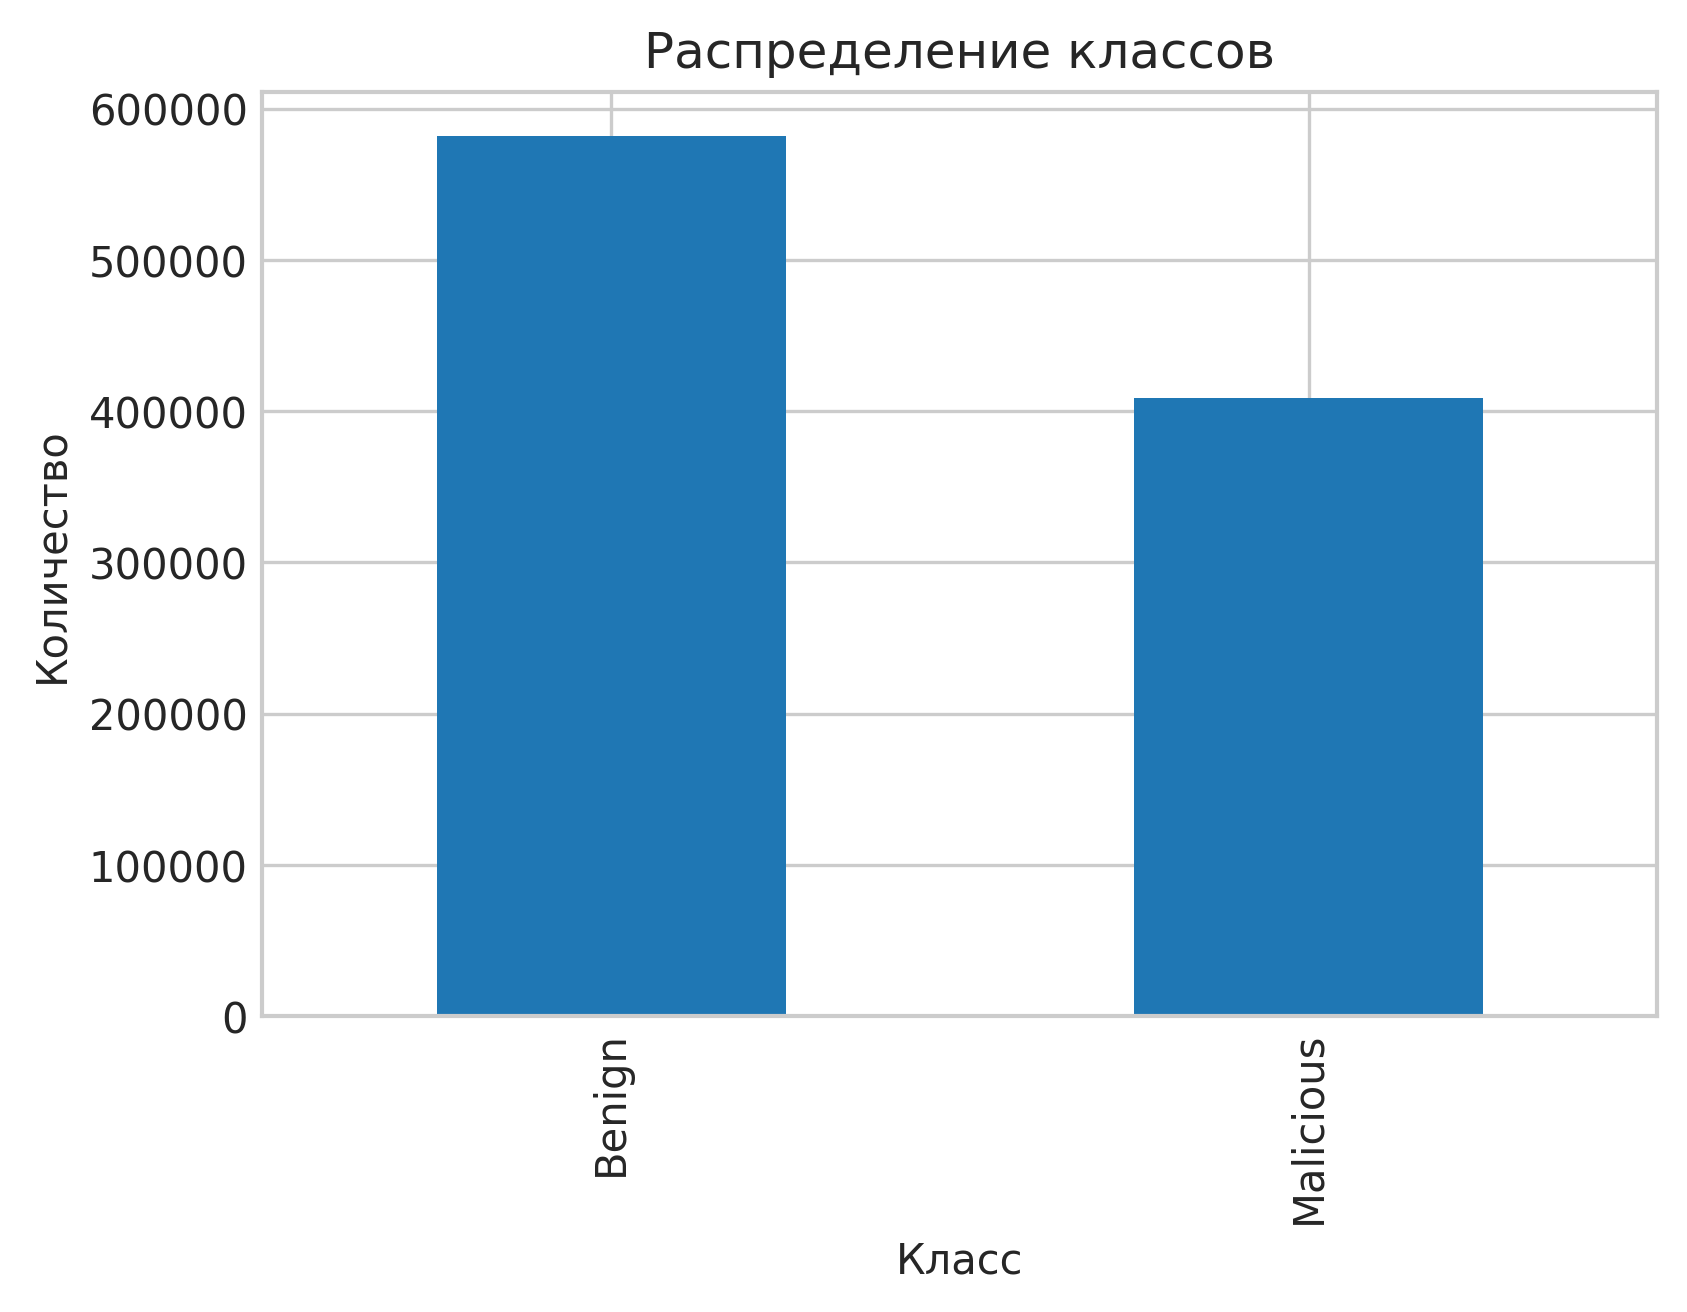

In [12]:
df_label['label'].value_counts().plot(kind='bar', figsize=(6,4))
plt.title('Распределение классов')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.show()

#### Распределения категориальных признаков

In [13]:
cat_cols = ['proto', 'service', 'conn_state', 'history']

TOP_N = 10

count_tables = {}
rate_tables = {}

for col in cat_cols:
    top_vals = df_copy[col].value_counts().nlargest(TOP_N).index
    sub = df_copy[df_copy[col].isin(top_vals)]
    
    counts = pd.crosstab(sub[col], df_label['label']).reindex(top_vals)
    count_tables[col] = counts
    
    rates = counts.div(counts.sum(axis=1), axis=0)['Malicious']
    rate_tables[col] = rates

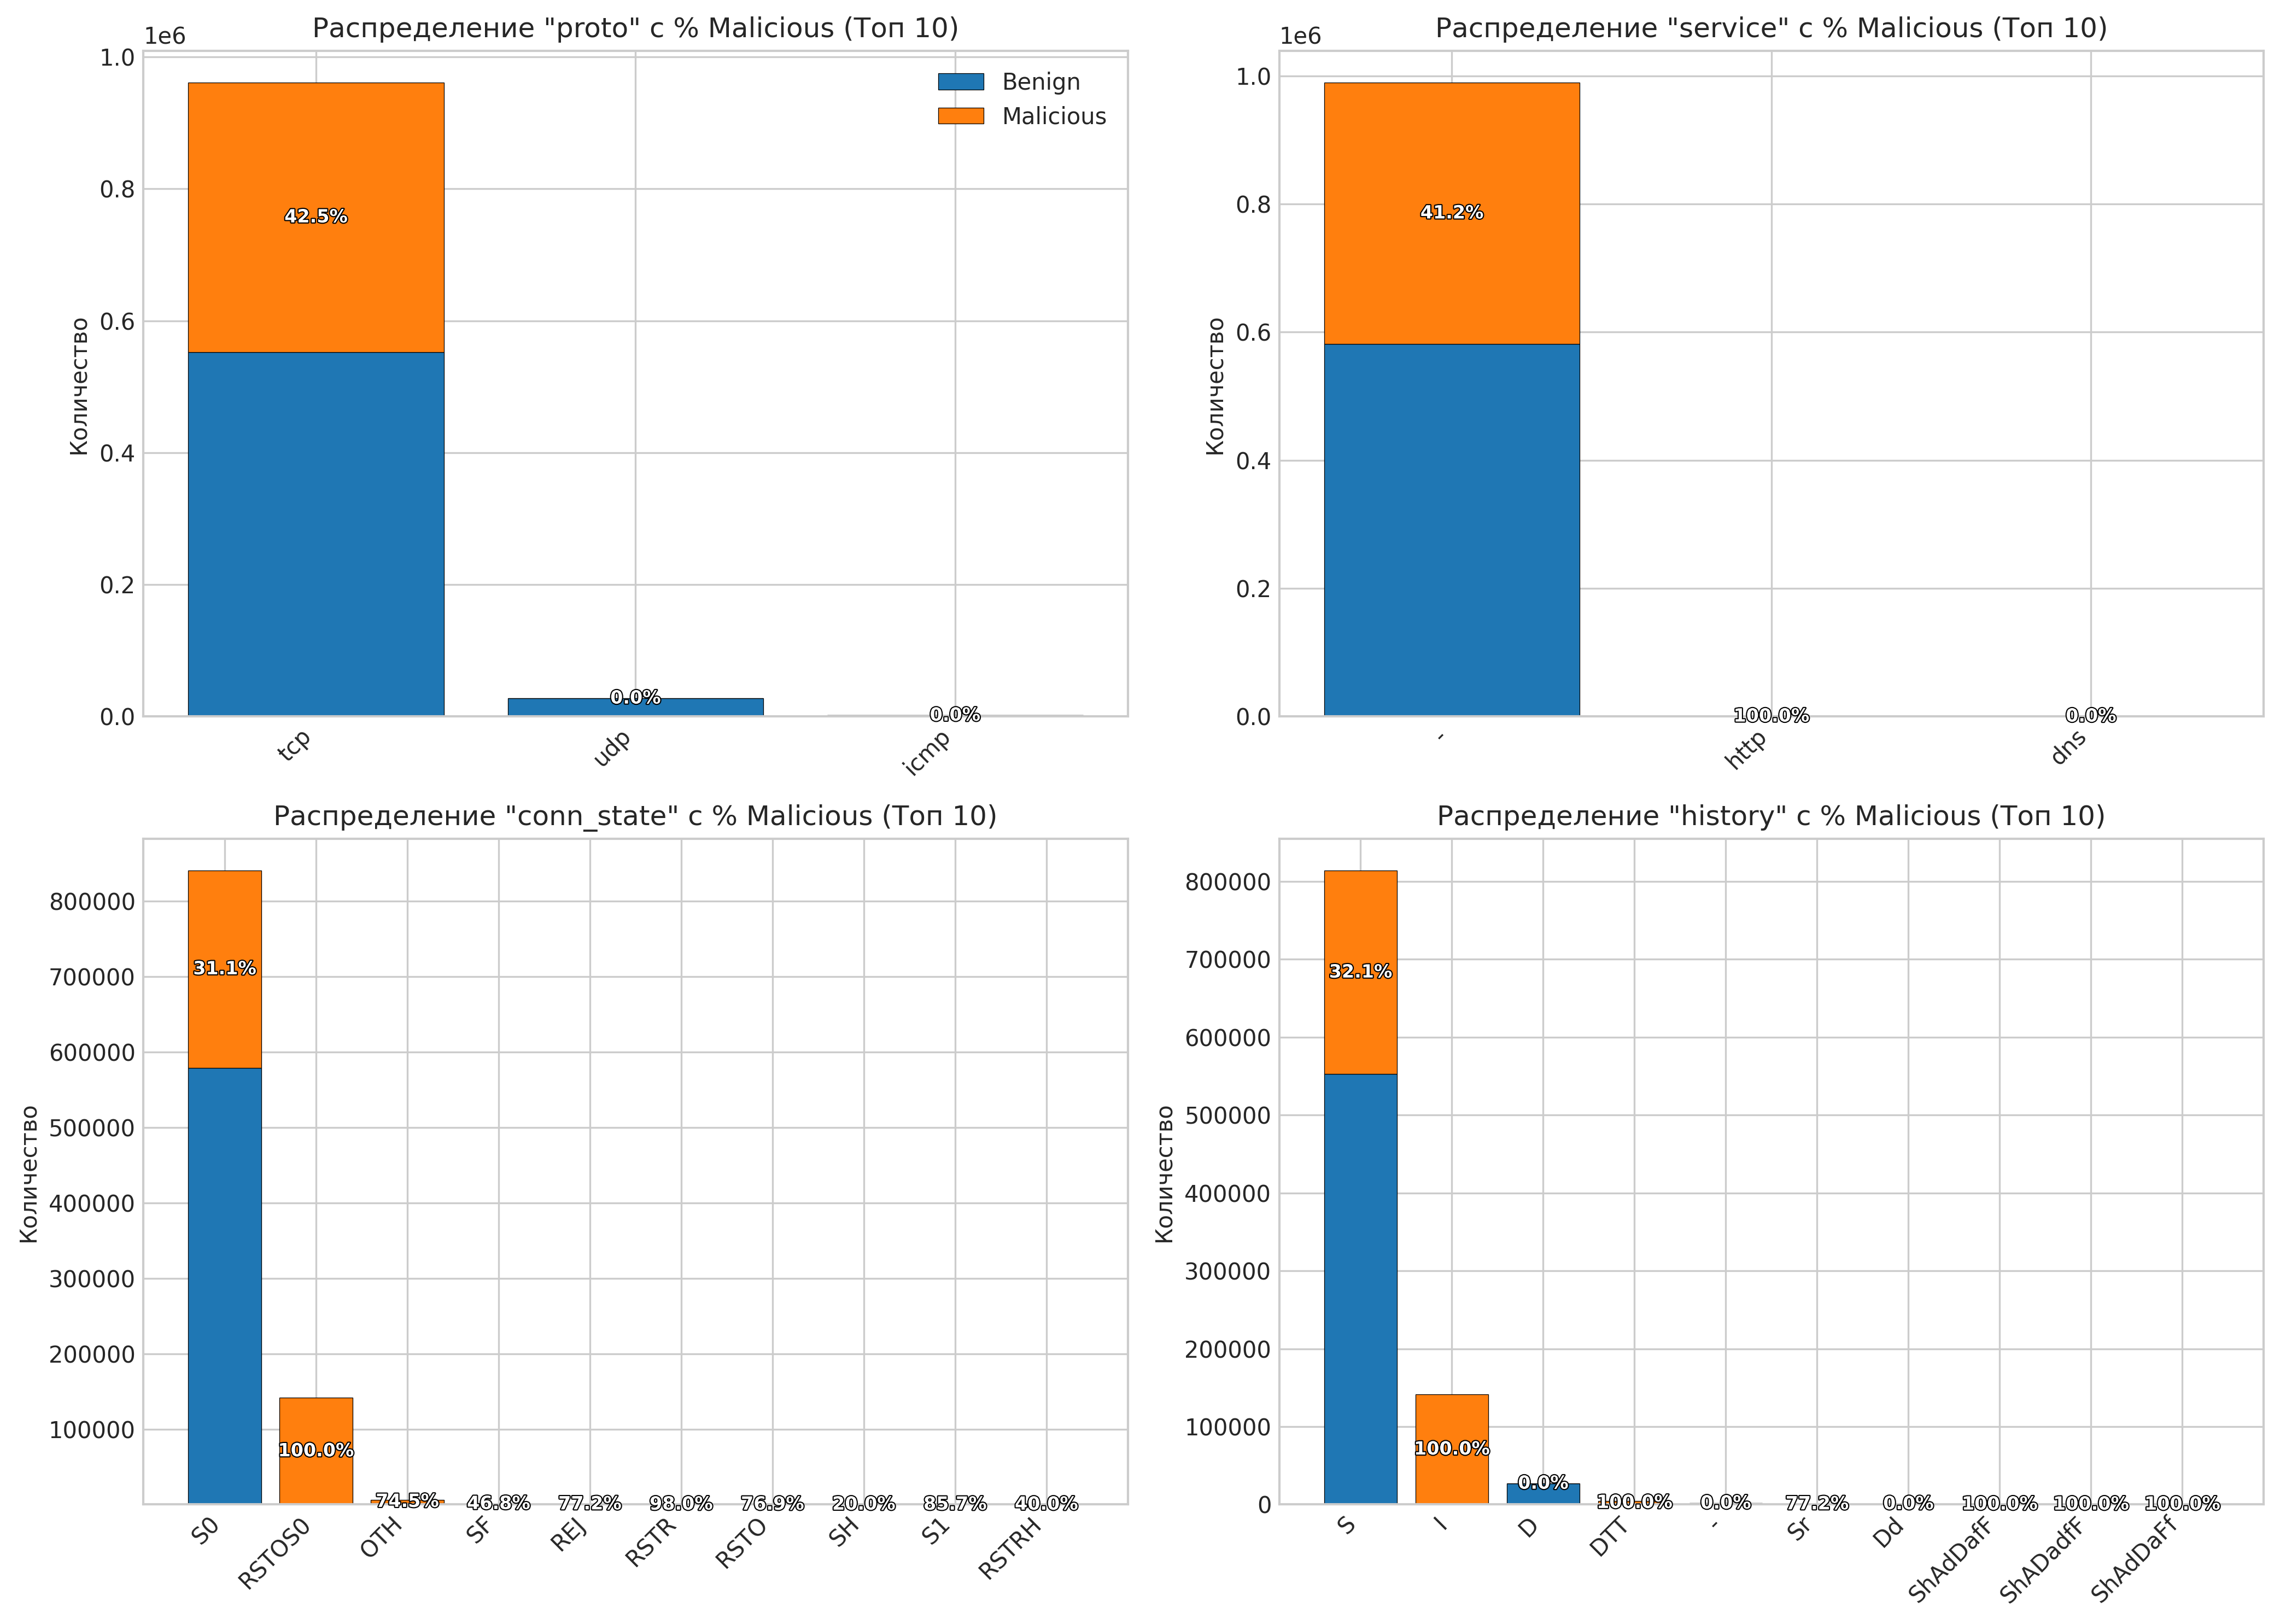

In [14]:
plt.rcParams.update({'font.size': 10})

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for ax, col in zip(axes, cat_cols):
    counts = count_tables[col]
    x = np.arange(len(counts))

    benign = counts['Benign'].values
    malicious = counts['Malicious'].values

    ax.bar(x, benign, label='Benign', edgecolor='black', linewidth=0.3)
    bars_mal = ax.bar(x, malicious, bottom=benign, label='Malicious', edgecolor='black', linewidth=0.3)

    for idx, bar in enumerate(bars_mal):
        total = benign[idx] + malicious[idx]
        if total == 0:
            continue
        pct = malicious[idx] / total * 100

        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_y() + bar.get_height() / 2,
            f'{pct:.1f}%',
            ha='center', va='center',
            fontsize=8, color='white', weight='bold',
            path_effects=[pe.withStroke(linewidth=1, foreground='black')]
        )

    ax.set_title(f'Распределение "{col}" с % Malicious (Топ {TOP_N})')
    ax.set_xticks(x)
    ax.set_xticklabels(counts.index, rotation=45, ha='right')
    ax.set_ylabel('Количество')

    if col == cat_cols[0]:
        ax.legend()

fig.tight_layout()

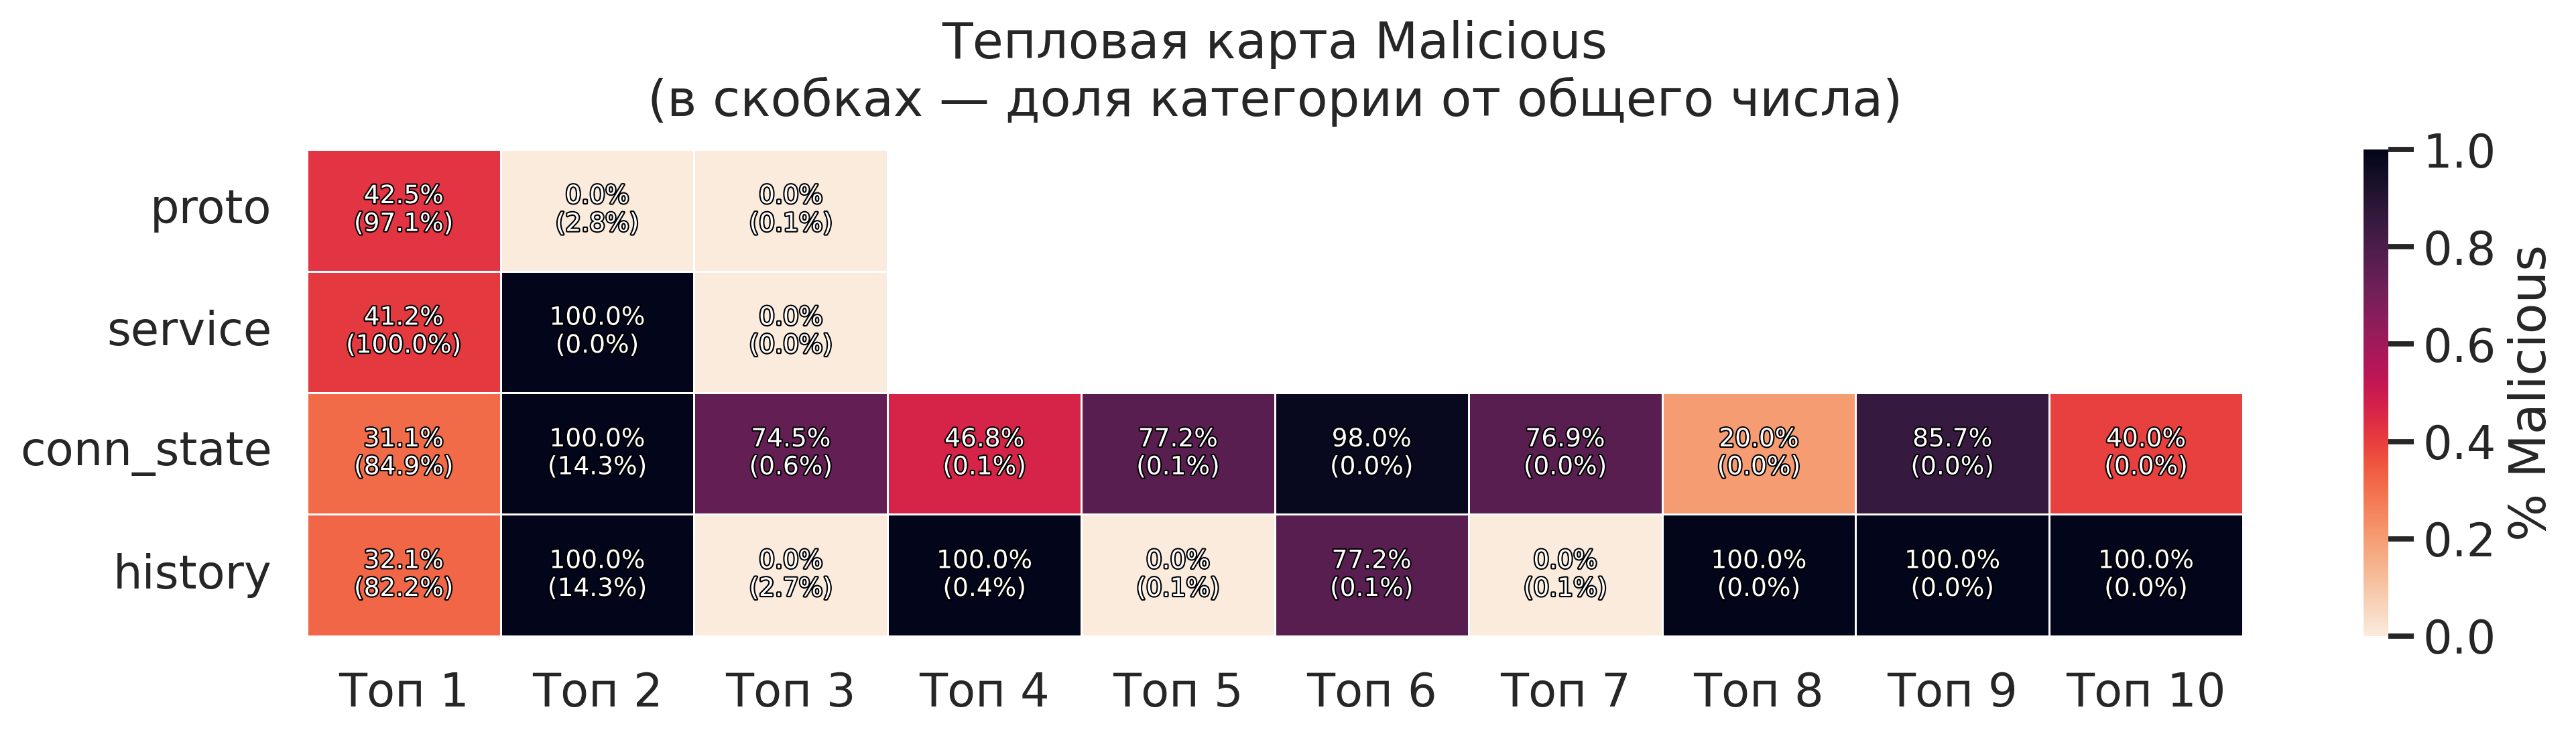

In [15]:
heatmap_df = pd.DataFrame(index=cat_cols, columns=range(TOP_N))
for col in cat_cols:
    rates = rate_tables[col]
    heatmap_df.loc[col, :len(rates)-1] = rates.values
hm = heatmap_df.astype(float)

cs = pd.DataFrame(index=cat_cols, columns=range(TOP_N), dtype=float)
for col in cat_cols:
    total_counts = (count_tables[col]['Benign'] +
                    count_tables[col]['Malicious']).values
    share = total_counts / total_counts.sum() * 100
    cs.loc[col, :len(share)-1] = share.round(1)

annot = pd.DataFrame(index=hm.index, columns=hm.columns, dtype=object)
for r in hm.index:
    for c in hm.columns:
        mal = hm.loc[r, c]
        cnt = cs.loc[r, c]
        if pd.notna(mal) and pd.notna(cnt):
            annot.loc[r, c] = f'{mal*100:.1f}%\n({cnt:.1f}%)'
        else:
            annot.loc[r, c] = ""
            
sns.set_theme(style="white", context="talk")

fig, ax = plt.subplots(figsize=(14, 4))
sns.heatmap(
    hm, cmap="rocket_r", vmin=0, vmax=1,
    linewidths=.6, linecolor="white",
    annot=annot, fmt='',
    annot_kws={
        "fontsize":9, "color":"white", "ha":"center",
        "path_effects":[pe.withStroke(linewidth=1, foreground="black")]
    },
    cbar_kws={"label": "% Malicious"}
)

ax.set_xticklabels([f'Топ {i+1}' for i in range(TOP_N)])
ax.set_title("Тепловая карта Malicious\n(в скобках — доля категории от общего числа)", pad=12)
ax.set_xlabel("")
ax.set_ylabel("")

fig.tight_layout()

#### Распределения числовых признаков

In [16]:
numeric_cols = df_copy.select_dtypes(include=["int64", "float64"]).columns.tolist()

In [17]:
df_copy[numeric_cols].describe().T

count          mean           std  min      25%  \
id.orig_p      990058.0  4.461100e+04  1.170562e+04  0.0  38312.0   
id.resp_p      990058.0  1.180929e+03  6.492709e+03  0.0     23.0   
duration       990058.0  2.107794e+00  6.596687e+00  0.0      0.0   
orig_bytes     990058.0  1.429007e+08  2.204914e+09  0.0      0.0   
resp_bytes     990058.0  1.810227e-01  1.137543e+01  0.0      0.0   
orig_pkts      990058.0  2.866000e+00  4.290982e+00  0.0      1.0   
orig_ip_bytes  990058.0  1.592178e+02  2.183359e+02  0.0     60.0   
resp_pkts      990058.0  1.086906e-02  4.892464e-01  0.0      0.0   
resp_ip_bytes  990058.0  6.771543e-01  3.123596e+01  0.0      0.0   

                        50%           75%           max  
id.orig_p      45412.000000  53366.000000  6.553500e+04  
id.resp_p         23.000000     23.000000  6.553000e+04  
duration           2.488457      3.126992  2.930102e+02  
orig_bytes         0.000000      0.000000  6.261674e+10  
resp_bytes         0.000000      0.000000  2.780000e+03  
orig_pkts          2.000000      3.000000  8.900000e+01  
orig_ip_bytes    120.000000    180.000000  4.450000e+03  
resp_pkts          0.000000      0.000000  6.600000e+01  
resp_ip_bytes      0.000000      0.000000  4.202000e+03

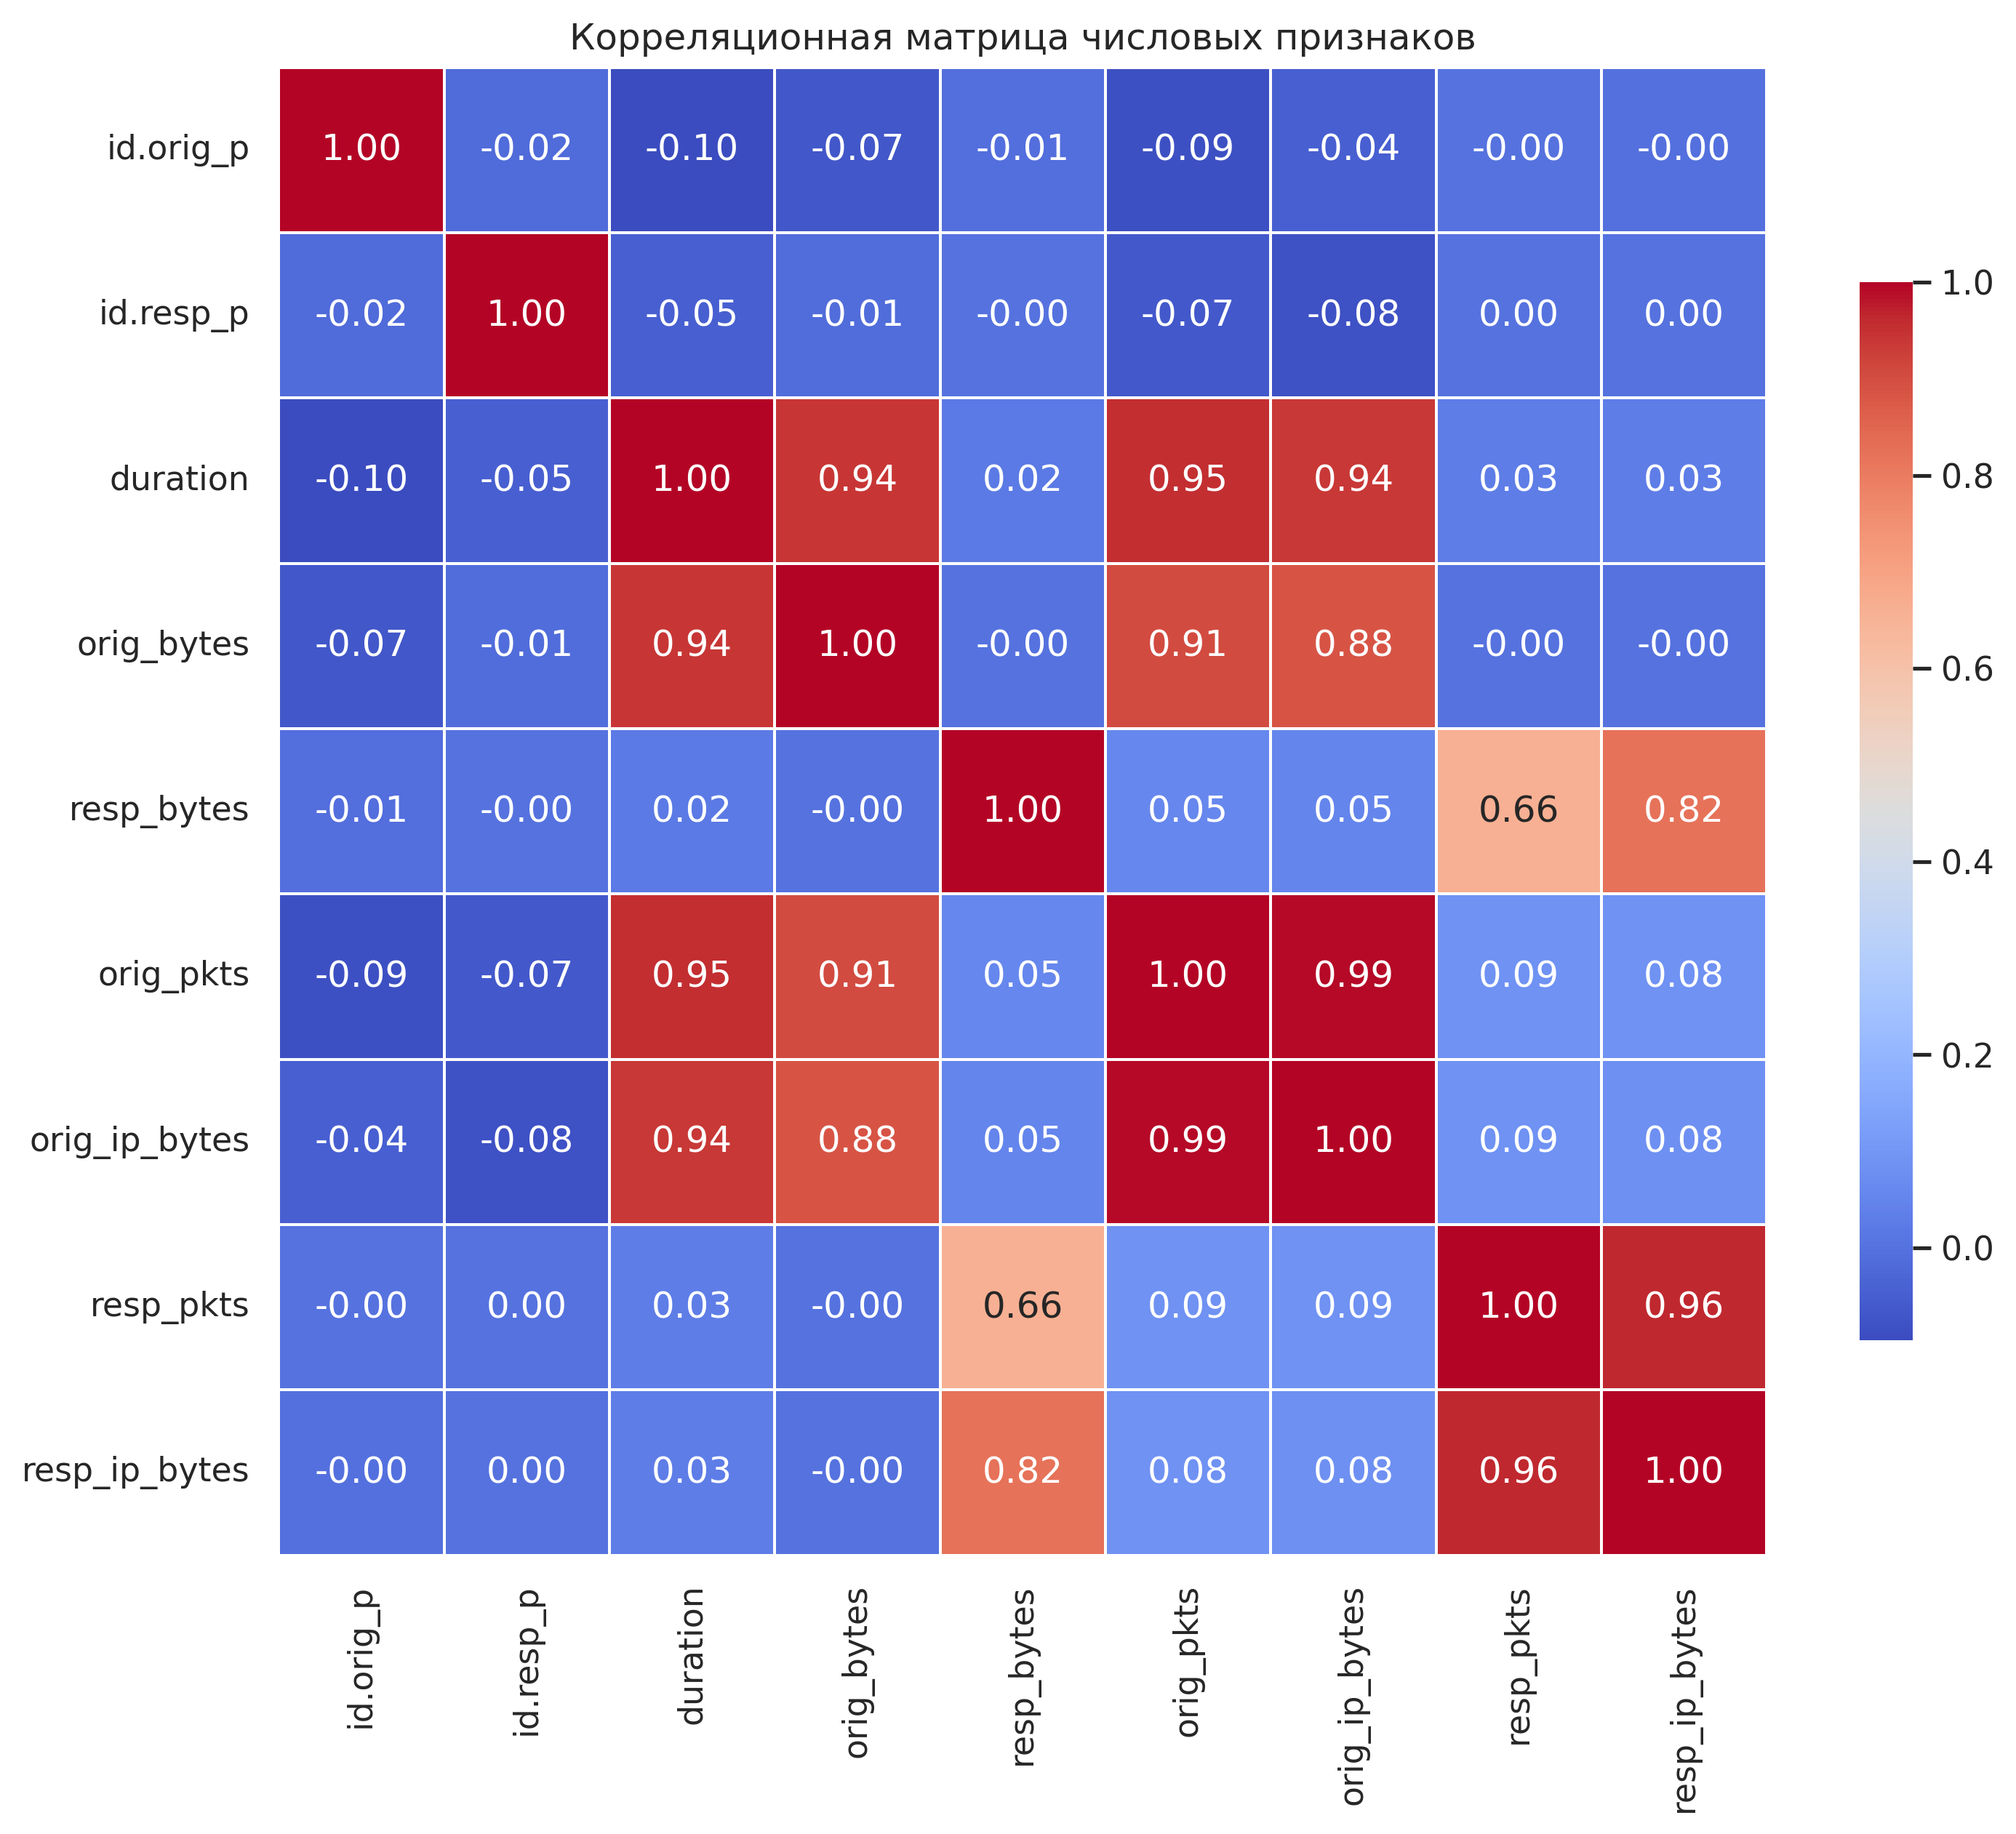

In [18]:
corr = df_copy[numeric_cols].corr(method="pearson")

sns.set_theme(style="whitegrid", context="notebook")

plt.figure(figsize=(11, 9))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=.5,
    cbar_kws={"shrink": .7},
    square=True
)

plt.title("Корреляционная матрица числовых признаков")
plt.show()

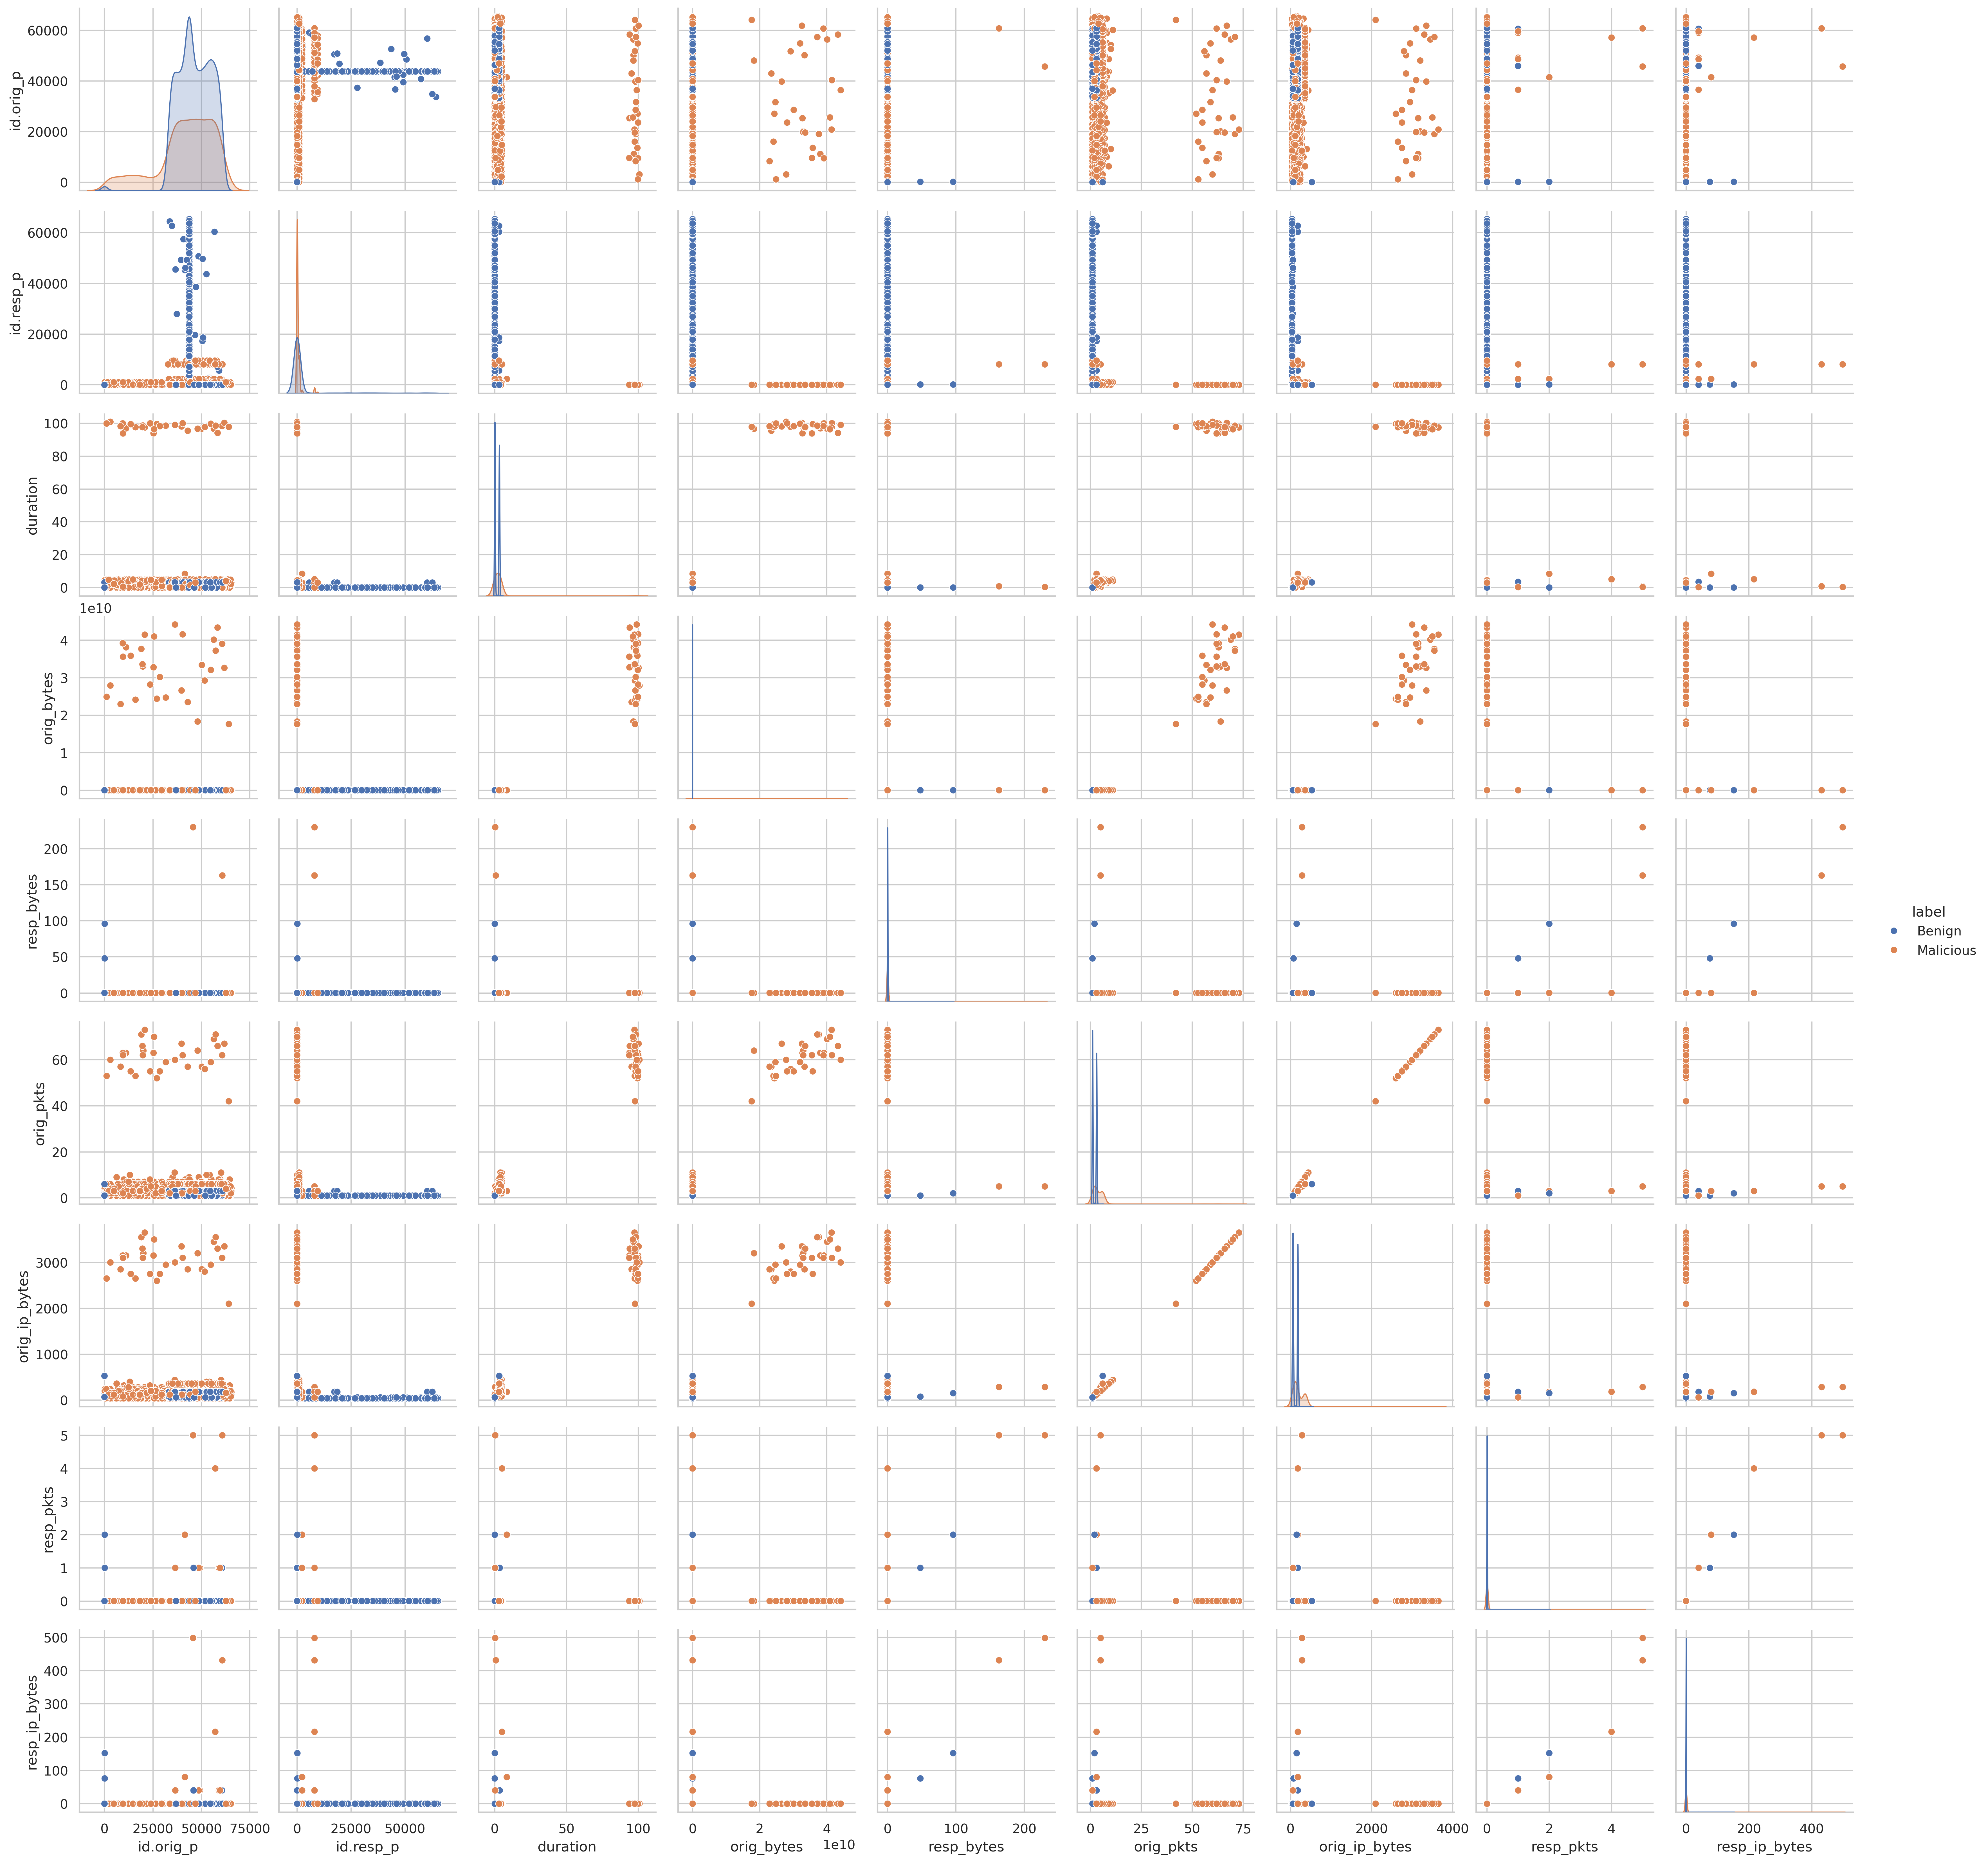

In [19]:
size_sample = 8000
random_state = 42

pair_df = df_copy.sample(n=size_sample, random_state=random_state)

sns.pairplot(
    pair_df,
    vars=numeric_cols,
    hue="label",
)

plt.show()

#### Выводы

* Баланс классов умеренный (но с метриками всё равно надо быть аккуратнее).
* По `proto` тяжело что-то сказать, а вот в `service`, `conn_state` и `history` много практически на 100% злонамеренных категорий, которые почти сразу можно брать за правило.
* Признаки `orig_pkts` и `orig_ip_bytes` (так же, как и `resp_bytes` и `resp_ip_bytes`) фактически дублируют друг друга (поэтому, можно было бы оставить только один).
* Остальные числовые признаки практически не коррелируют, поэтому деревьям/градиентым бустингам будет хорошо.

In [20]:
df_copy.drop(columns=['label'], inplace=True)

gc.collect()

3241

## Подготовка данных и обучение моделей

### Кодирование категориальных признаков

Будем использовать два подхода: `OneHotEncoding` и `OrdinalEncoding`.

Использовать что-либо одно - плохо. Если использовать только `OneHotEncoding`, то из-за `history` будет создаваться гигантская разреженная матрица. С другой стороны, если использовать только `OrdinalEncoding`, то это может ввести модель в заблуждение (может найти зависимости, которых нет).

Поэтому, чтобы найти компромисс, для `proto`, `service` и `conn_state` будем использовать `OneHotEncoding`, а для `history` - `OrdinalEncoding`.

Вообще говоря, так-то это и неплохо, поскольку на `history` можно ввести частичный порядок ($x \leq y$, если кол-во `conn_state` в $y$ больше или равно кол-ву `conn_state` в $x$).

In [21]:
cat_cols_oh = ['proto', 'service', 'conn_state']

cat_cols_ord = ['history']

In [22]:
from sklearn.preprocessing import OneHotEncoder

print('Before one-hot encoding:')
print(df_copy.values[0])
print(df_copy.shape)

df_cat = df_copy[cat_cols_oh]

ohe = OneHotEncoder(
    handle_unknown='ignore',
    sparse_output=False,
    drop='first'
)

encoded = ohe.fit_transform(df_cat)

new_cols = ohe.get_feature_names_out(cat_cols_oh)

df_ohe = pd.DataFrame(encoded, columns=new_cols, index=df_copy.index)

df_copy = pd.concat([df_copy.drop(columns=cat_cols_oh), df_ohe], axis=1)

print('After one-hot encoding:')
print(df_copy.values[0])
print(df_copy.shape)

Before one-hot encoding:
[40928 23 'tcp' '-' 0.0 0 0 'S0' 'S' 1 60 0 0]
(990058, 13)
After one-hot encoding:
[40928 23 0.0 0 0 'S' 1 60 0 0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0
 0.0 0.0 0.0]
(990058, 24)


In [23]:
gc.collect()

228767

In [24]:
from sklearn.preprocessing import OrdinalEncoder

print('Before ordinal encoding:')
print(df_copy.values[0])
print(df_copy.shape)

enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

df_copy[cat_cols_ord] = enc.fit_transform(df_copy[cat_cols_ord])

print('After ordinal encoding:')
print(df_copy.values[0])
print(df_copy.shape)

Before ordinal encoding:
[40928 23 0.0 0 0 'S' 1 60 0 0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0
 0.0 0.0 0.0]
(990058, 24)
After ordinal encoding:
[4.0928e+04 2.3000e+01 0.0000e+00 0.0000e+00 0.0000e+00 1.2000e+01
 1.0000e+00 6.0000e+01 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
(990058, 24)


In [25]:
gc.collect()

0

Осталось только закодировать `df_label`. Но тут всё просто: `Benign` $\rarr 0$, `Malicious` $\rarr 1$

In [26]:
from sklearn.preprocessing import LabelEncoder

print(df_label.head(10))

le = LabelEncoder()
y = le.fit_transform(df_label['label'])

print(y[0:10])

       label
0     Benign
1     Benign
2     Benign
3  Malicious
4     Benign
5  Malicious
6  Malicious
7     Benign
8     Benign
9  Malicious
[0 0 0 1 0 1 1 0 0 1]


### Разбиение данных

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_copy, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train size:", X_train.shape, y_train.shape)
print("Test size:", X_test.shape,  y_test.shape)

Train size: (792046, 24) (792046,)
Test size: (198012, 24) (198012,)


В результате дальнейшей работы оказалось, что такой размер тренировочной выборки слишком сильно влияет на время работы (компьютер не справляется), поэтому из `X_train` отделим 200000 экземпляров, которые будем использовать для такой своеобразной валидации.

In [28]:
extra_idx = X_train.sample(n=200_000, random_state=42).index

X_test_extra = X_train.loc[extra_idx].copy()
y_train_series = pd.Series(y_train, index=X_train.index)
y_test_extra = y_train_series.loc[extra_idx].copy()

X_train = X_train.drop(index=extra_idx)
y_train_series = y_train_series.drop(index=extra_idx)

y_train = y_train_series.values

print("Осталось в X_train:", X_train.shape)
print("В X_test_extra:", X_test_extra.shape)

Осталось в X_train: (592046, 24)
В X_test_extra: (200000, 24)


### Стандартизация признаков

Для повышения качества моделей логистической регрессии и k-NN воспользуемся `StandartScaler`.

In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

### Построение модели логистической регрессии

Подбор гиперпараметров осуществлялся с помощью `GridSearchCV` с `cv=5` и `scoring='roc_auc'`.

Настройки кандидатов:
* `C`: `[1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]`
* `penalty`: `['l2']`
* `class_weight`: `['none', 'balanced']`
* `solver`: `['liblinear']`

В силу того, что процесс подбора гиперпараметров оказася очень долгим, тут его не будет. Обучим модель сразу на лучших, а именно:
* `C=100`
* `penalty='l2'`
* `class_weight='balanced'`
* `solver='liblinear'`

In [30]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(
    random_state=42,
    max_iter=1000,
    C=100,
    penalty='l2',
    class_weight='balanced',
    solver='liblinear'
)

# Обучение делаем не на всех 800k, а на случайных 20k, чтобы ускорить процесс
idx = np.random.choice(len(X_train_s), size=20_000, replace=False)
lr.fit(X_train_s[idx], y_train[idx])

LogisticRegression(C=100, class_weight='balanced', max_iter=1000,
                   random_state=42, solver='liblinear')

### Построение модели k-NN

Подбор гиперпараметров осуществлялся с помощью `RandomizedSearchCV` с `n_iter=20`, `cv=5` и `scoring='roc_auc'`.

Настройки кандидатов:
* `n_neighbors`: `np.arange(1, 100, 2)`
* `weights`: `['uniform', 'distance']`
* `p`: `[1, 2]`

Аналогично как мы делали для логистической регрессии, здесь проводить подбор гиперпараметров не будем. Сразу обучим на лучших, а именно:
* `n_neighbors=47`
* `weights='distance'`
* `p=2`

In [31]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(
    n_neighbors=47,
    weights='distance',
    p=2
)

knn.fit(X_train_s[idx], y_train[idx])

KNeighborsClassifier(n_neighbors=47, weights='distance')

### Построение модели XGBoost

В отличие от предыдущих моделей XGBoost не требует стандартизации признаков для повышения качества модели, что сильно снижает нагрузку на подбор гиперпараметров. Поэтому проведём его прямо здесь (для предыдущих делалось точно так же):

In [32]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

xgb = XGBClassifier(random_state=42, eval_metric='auc')

param_dist = {
    'n_estimators': [50, 75, 100, 150, 200, 250, 300, 400],
    'max_depth': [3, 5, 7, 9, 11],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5]
}

search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

search.fit(X_train.values[idx], y_train[idx])

xgb = search.best_estimator_
print("\nЛучшие параметры:", search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Лучшие параметры: {'subsample': 0.6, 'n_estimators': 250, 'max_depth': 11, 'learning_rate': 0.2, 'gamma': 1, 'colsample_bytree': 0.8}


## Оценка и сравнение качества моделей

Посмотрим на базовые метрики каждой модели:

In [33]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score,
    confusion_matrix
)

Логистическая регрессия:

In [34]:
y_pred  = lr.predict(X_test_s)
y_proba = lr.predict_proba(X_test_s)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9669

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97    116330
           1       0.99      0.93      0.96     81682

    accuracy                           0.97    198012
   macro avg       0.97      0.96      0.97    198012
weighted avg       0.97      0.97      0.97    198012

AUC-ROC: 0.9923

Confusion Matrix:
[[115708    622]
 [  5926  75756]]


k-NN:

In [35]:
y_pred  = knn.predict(X_test_s)
y_proba = knn.predict_proba(X_test_s)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9783

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98    116330
           1       0.99      0.96      0.97     81682

    accuracy                           0.98    198012
   macro avg       0.98      0.97      0.98    198012
weighted avg       0.98      0.98      0.98    198012

AUC-ROC: 0.9887

Confusion Matrix:
[[115643    687]
 [  3604  78078]]


XGBoost:

In [36]:
y_pred  = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# дополнительные данные, которые мы отделяли от X_train
y_pred  = xgb.predict(X_test_extra)
y_proba = xgb.predict_proba(X_test_extra)[:, 1]

print(f"\nAccuracy: {accuracy_score(y_test_extra, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_extra, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_test_extra, y_proba):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_extra, y_pred))

Accuracy: 0.9871

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    116330
           1       1.00      0.97      0.98     81682

    accuracy                           0.99    198012
   macro avg       0.99      0.98      0.99    198012
weighted avg       0.99      0.99      0.99    198012

AUC-ROC: 0.9931

Confusion Matrix:
[[116148    182]
 [  2371  79311]]

Accuracy: 0.9870

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    117350
           1       1.00      0.97      0.98     82650

    accuracy                           0.99    200000
   macro avg       0.99      0.98      0.99    200000
weighted avg       0.99      0.99      0.99    200000

AUC-ROC: 0.9930

Confusion Matrix:
[[117184    166]
 [  2438  80212]]


Теперь построим ROC-кривые, Precision-Recall кривые и калибровочные кривые:

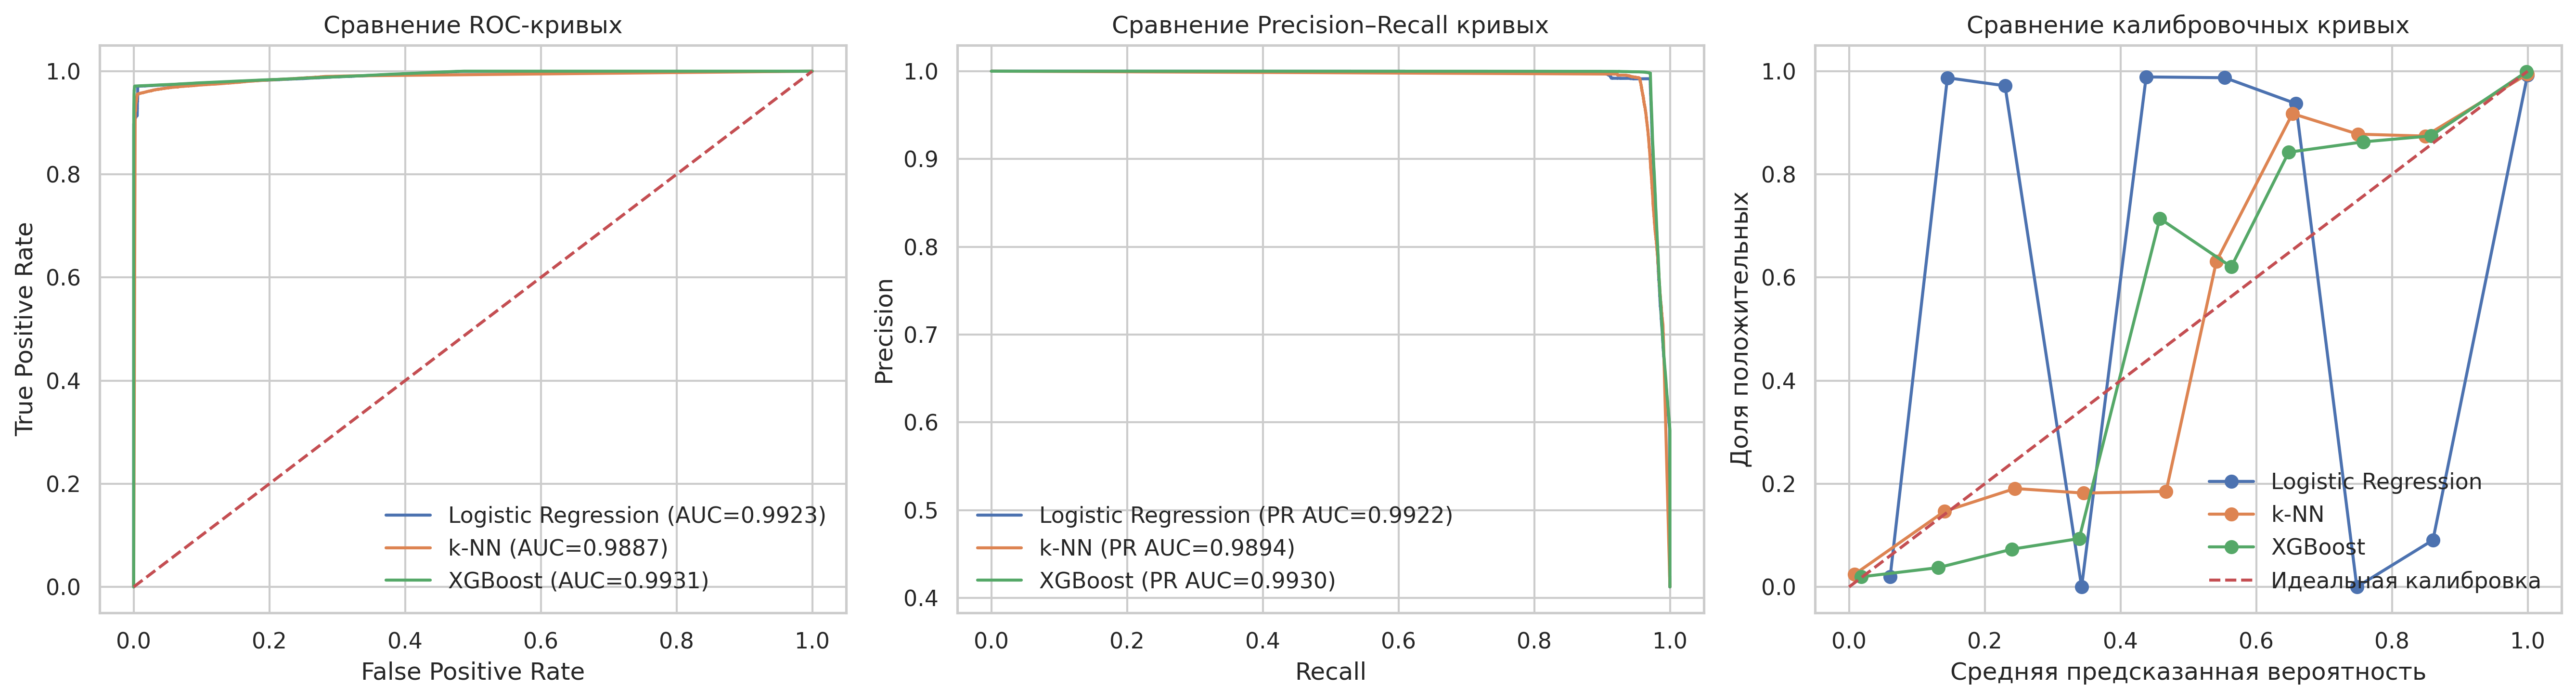

In [37]:
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    auc as calc_auc
)
from sklearn.calibration import calibration_curve

models = {
    'Logistic Regression': lr,
    'k-NN': knn,
    'XGBoost': xgb
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

ax = axes[0]
for name, model in models.items():
    if model == xgb:
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.predict_proba(X_test_s)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)
    ax.plot(fpr, tpr, label=f'{name} (AUC={auc_score:.4f})')
ax.plot([0,1], [0,1], '--')
ax.set_title('Сравнение ROC-кривых')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()
ax.grid(True)

ax = axes[1]
for name, model in models.items():
    if model == xgb:
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.predict_proba(X_test_s)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = calc_auc(recall, precision)
    ax.plot(recall, precision, label=f'{name} (PR AUC={pr_auc:.4f})')
ax.set_title('Сравнение Precision–Recall кривых')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend()
ax.grid(True)

ax = axes[2]
for name, model in models.items():
    if model == xgb:
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.predict_proba(X_test_s)[:, 1]
    prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)
    ax.plot(prob_pred, prob_true, marker='o', label=name)
ax.plot([0,1], [0,1], '--', label='Идеальная калибровка')
ax.set_title('Сравнение калибровочных кривых')
ax.set_xlabel('Средняя предсказанная вероятность')
ax.set_ylabel('Доля положительных')
ax.legend()
ax.grid(True)

fig.tight_layout()

### Выводы и рекомендации

XGBoost чуть лучше всех разделяет "хорошие" и "плохие" образцы (самая высокая ROC-AUC и минимальное число пропусков вредоносных подключений) при очень малом числе ложных тревог, тогда как логистическая регрессия почти не уступает ему по AUC, но чуть больше пропускает "плохих", а k-NN отстаёт и при этом медленнее. Поэтому наилучшим вариантом будет **XGBoost**.

При этом все три модели без дополнительной калибровки переоценивают или недооценивают вероятности (хуже всех в этом плане оказалась логистическая регрессия), так что для надёжного подбора порога стоит выполнить `CalibratedClassifierCV` и выбрать оптимальный:
* Жёсткий (скажем 0.2) для немедленного блокирования точно вредоносных.
* Мягкий (скажем 0.7) для ручной проверки сомнительных подключений.

Также можно продолжить анализировать признаки, посмотреть, какие оказались наиболее важными для XGBoost, пробовать разные кодировки категориальных признаков и т.д..